# **Data Visualisation Notebook**

## Objectives

* Fulfill Business Requirement 1 - differentiate between healthy cherry leaves and those with powdery mildew. 

## Inputs

* inputs/cherry_leaves_dataset/cherry_leaves/train
* inputs/cherry_leaves_dataset/cherry_leaves/validation
* inputs/cherry_leaves_dataset/cherry_leaves/test

## Outputs

* Scatterplot of image height and width.
* Image shape embeddings in a pickle file.
* Standard deviation and mean of images per label.
* A plot to show image differences between the two classes.
* Image montage. 


---

# Set Working Directories

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cherry-leaves-mildew-detection/jupyter_notebooks'

In [2]:
os.chdir("/workspace/cherry-leaves-mildew-detection")
print("You set a new current directory.")

You set a new current directory.


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-leaves-mildew-detection'

### Set Input Directories

In [4]:
data_dir = "inputs/cherry_leaves_dataset/cherry_leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

### Set Output Directory

In [5]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory exists, create a new version.")
else:
    os.makedirs(name=file_path)

This directory exists, create a new version.


### Set Label Names

In [6]:
labels = os.listdir(train_dir)
print("The image labels are", labels)

The image labels are ['healthy', 'powdery_mildew']


# Image Shape

### Plot Height and Width

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

def plot_height_width():
    """
    Function to plot height and width in a scatterplot and
    return the mean height and mean width.
    """

    image_height, image_width = [], []
    for label in labels:
        for file in os.listdir(train_dir + "/" + label):
            image = imread(train_dir + "/" + label + "/" + file)
            height, width, color = image.shape
            image_height.append(height)
            image_width.append(width)

    sns.set_theme(style="darkgrid", palette="bright")
    fig, axes = plt.subplots()
    sns.scatterplot(x=image_width, y=image_height, alpha=0.5)
    axes.set_xlabel("Width (pixels)")
    axes.set_ylabel("Height (pixels)")
    axes.set_title("Height and Width of Cherry Leaves Images")

    # To calculate the mean height and width
    height_mean = int(np.array(image_height).mean())
    width_mean = int(np.array(image_width).mean())

    # Save image if it is not in directory
    if "height_width_plot.png" not in file_path:
        plt.savefig(f"{file_path}/height_width_plot.png")
    else:
        plt.show()
    print(f"The average image height is {height_mean} and the average image width is {width_mean}.")

    return height_mean, width_mean

The average image height is 256 and the average image width is 256.


(256, 256, 3)

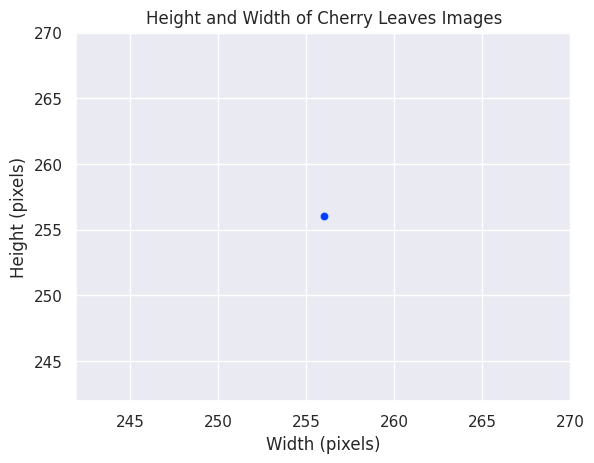

In [8]:
height_mean, height_width = plot_height_width()
image_shape = (height_mean, height_width, 3)
image_shape

Every image in the dataset is of the same exact height and width. 

### Save Image Shape

In [9]:
if "image_shape_embed.pkl" not in file_path:
    joblib.dump(value=image_shape, filename=f"{file_path}/image_shape_embed.pkl")

---

# Data Visualisation

### Load Images as Array

In [13]:
from tensorflow.keras.preprocessing import image

def load_images_in_array(data_dir, new_size=(50,50), n_images_per_label=20):
    """
    Function to load images in array.
    """
    # Set X as an interger and y as an object
    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    labels = os.listdir(data_dir)

    for label in labels:
        count = 0
        for image_file in os.listdir(data_dir + "/" + label):
            # Stop when count reaches this number to save time
            if count < n_images_per_label:
                file = image.load_img(data_dir + "/" + label + "/" + image_file, color_mode="rgb", target_size=new_size)
                # Resize the image only if the max pixel value is above 1
                if image.img_to_array(file).max() > 1:
                    resized_image = image.img_to_array(file) / 255
                else:
                    resized_image = image.img_to_array(file)
                X = np.append(X, resized_image).reshape(-1, new_size[0], new_size[1], resized_image.shape[2])
                y = np.append(y, label)
                count += 1

    return X, y

In [14]:
X, y = load_images_in_array(data_dir=train_dir, new_size=image_shape, n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Average Image and Image Variability

In [23]:
def plot_image_mean_and_variability_as_array(X, y, figsize=(10,5)):
    """
    Function to loop through the labels, subset an array for each label
    and caclulate/plot the standard deviation and mean.
    """
    sns.set_style("white")
    for label in np.unique(y):
        # Subset an array
        y = y.reshape(-1,1,1)
        boolean_mask = np.any(y==label, axis=1).reshape(-1)
        array = X[boolean_mask]

        # Calculate the mean per label
        mean_image = np.mean(array, axis=0)
        # Calculate the variability per label
        std_image = np.std(array, axis=0)

        print(f"Label: {label}")
        print(f"Image shape: {mean_image.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for {label}")
        axes[0].imshow(mean_image, cmap="gray")
        axes[1].set_title(f"Image Variability for {label}")
        axes[1].imshow(std_image, cmap="gray")
        if f"mean_std_{label}.png" not in {file_path}:
            plt.savefig(f"{file_path}/mean_std_{label}.png")
        else:
            plt.show()
            
        print("\n")

Label: healthy
Image shape: (256, 256, 3)


Label: powdery_mildew
Image shape: (256, 256, 3)




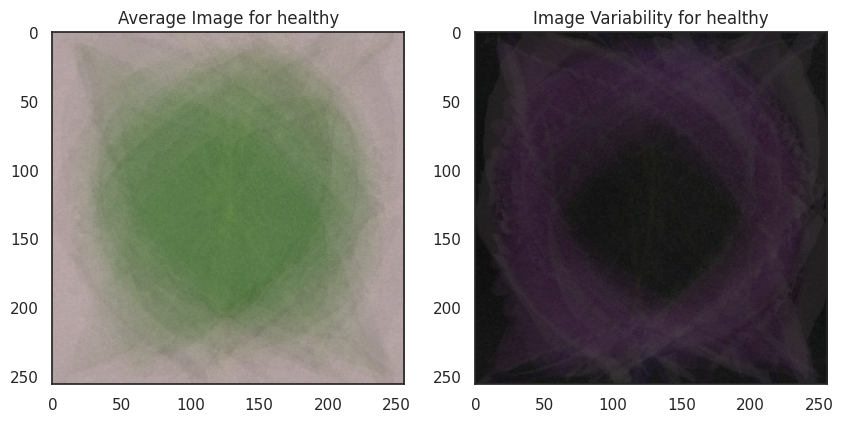

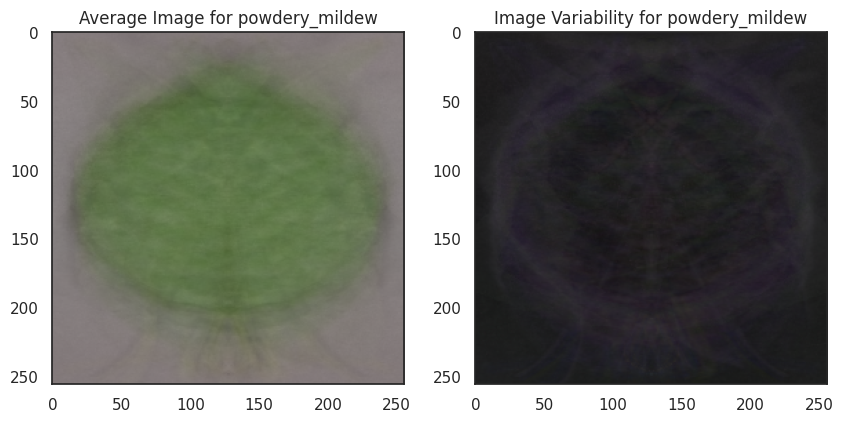

In [24]:
plot_image_mean_and_variability_as_array(X=X, y=y)

### Differences between Healthy and Powdery Mildew Images

In [43]:
def subset_image_for_label(X, y, label):
    """
    Function to subset the image per label
    """
    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label, axis=1).reshape(-1)
    df_cherry_leaves = X[boolean_mask]
    return df_cherry_leaves

def differences_between_two_labels(X, y, label_1, label_2, figsize=(15,10)):
    """
    Function to plot the average image and image differences between two labels.
    """
    sns.set_style("white")
    label_list = np.unique(y)

    if label_1 not in label_list:
        print(f"{label_1} is not in {label_list}.")
        return
    elif label_2 not in label_list:
        print(f"{label_2} is not in {label_list}.")
    
    image_1 = subset_image_for_label(X=X, y=y, label=label_1)
    image_1_mean = np.mean(image_1, axis=0)

    image_2 = subset_image_for_label(X=X, y=y, label=label_2)
    image_2_mean = np.mean(image_2, axis=0)

    differences = image_1_mean - image_2_mean

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    print("\n")
    axes[0].set_title(f"Average {label_1}")
    axes[0].imshow(image_1_mean, cmap="gray")
    axes[1].set_title(f"Average {label_2}")
    axes[1].imshow(image_2_mean, cmap="gray")
    axes[2].set_title(f"Differences: Average {label_1} and {label_2}")
    axes[2].imshow(differences, cmap="gray")
    if f"differences {label_1} and {label_2}.png" not in {file_path}:
        plt.savefig(f"{file_path}/differences {label_1} and {label_2}.png")
    else:
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


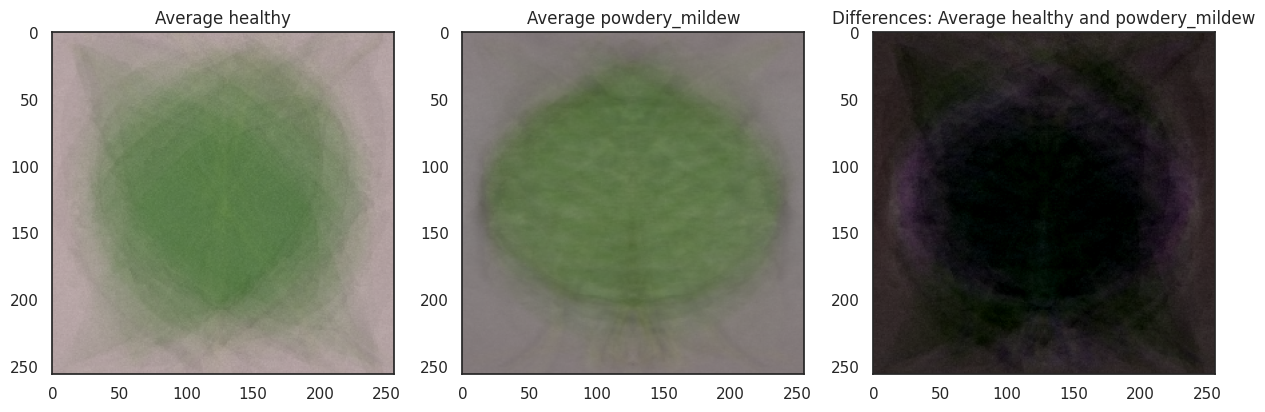

In [44]:
differences_between_two_labels(X=X, y=y, label_1="healthy", label_2="powdery_mildew")

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
